In [2]:
import pandas as pd
import numpy as np
import requests

In [2]:
import requests
import zipfile
import io

# URL of the ZIP file
url = "https://www.propertypriceregister.ie/website/npsra/ppr/npsra-ppr.nsf/Downloads/PPR-ALL.zip/$FILE/PPR-ALL.zip"

# Download the file
print("Downloading ZIP file...")
response = requests.get(url, verify=False)

# Check for successful response
if response.status_code == 200:
    print("Download successful, extracting contents...")

    # Use BytesIO to treat the downloaded bytes like a file
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    
    # Extract all contents into the current directory (or specify a path)
    zip_file.extractall("PPR-ALL")  # This will extract to a folder named "PPR-ALL"
    print("Extraction completed.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

C:\Users\mcalk\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.propertypriceregister.ie'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Download successful, extracting contents...
Extraction completed.


## Data Preprocessing

From an initial glance at the available property data, it's clear that there are a lot of adjustments required in order to make price predictions:

* The 'Address' column contains between 2 and 4 pieces of information, as well as variation in case.
* Many properties do not have Eircodes.
* The 'Date' and 'Price' columns need to be reformatted.

In [4]:
def split_address_column_detailed(df, address_column='Address'):
    """
    Assumes typical Irish address format: Street, Area/District, Town/City, County
    
    Args:
        df (pd.DataFrame): The dataframe containing the address column
        address_column (str): Name of the column to split
    
    Returns:
        pd.DataFrame: DataFrame with new columns for Street, Area, Town, County
    """
    
    df_copy = df.copy()
    
    # Initialize new columns
    df_copy['Street'] = ''
    df_copy['Area'] = ''
    df_copy['Town'] = ''
    df_copy['County_new'] = ''
    
    def split_irish_address(address):
        if pd.isna(address) or address == '':
            return ['', '', '', '']
        
        parts = [part.strip() for part in str(address).split(',')]
        
        if len(parts) == 1:
            return [parts[0], '', '', '']
        elif len(parts) == 2:
            # Assume: Street, Town (no area/county specified)
            return [parts[0], '', parts[1], '']
        elif len(parts) == 3:
            # Assume: Street, Town, Area 
            return [parts[0], parts[1], parts[2], '']
        elif len(parts) == 4:
            # Assume: Street, Area, Town, County
            return [parts[0], parts[1], parts[2], parts[3]]
        else:
            # More than 4 parts - keep first as street, combine middle parts
            return [parts[0], ', '.join(parts[1:-2]), parts[-2], parts[-1]]
    
    # Apply splitting
    split_results = df_copy[address_column].apply(split_irish_address)
    
    # Assign results
    df_copy['Street'] = [result[0] for result in split_results]
    df_copy['Area'] = [result[1] for result in split_results]
    df_copy['Town'] = [result[2] for result in split_results]
    df_copy['County_new'] = [result[3] for result in split_results]
    
    return df_copy

def analyze_address_patterns(df, address_column='Address'):
    """
    Analyzes the address column to show patterns and help decide on splitting strategy.
    
    Args:
        df (pd.DataFrame): The dataframe containing the address column
        address_column (str): Name of the column to analyze
    
    Returns:
        dict: Analysis results showing patterns in the data
    """
    
    if address_column not in df.columns:
        return {"error": f"Column '{address_column}' not found in dataframe"}
    
    analysis = {
        'total_rows': len(df),
        'non_empty_addresses': df[address_column].notna().sum(),
        'empty_addresses': df[address_column].isna().sum(),
        'comma_count_distribution': {},
        'examples_by_parts': {}
    }
    
    # Count commas in each address
    comma_counts = df[address_column].dropna().str.count(',')
    analysis['comma_count_distribution'] = comma_counts.value_counts().to_dict()
    
    # Get examples for each number of parts
    for comma_count in sorted(comma_counts.unique()):
        parts_count = comma_count + 1
        examples = df[df[address_column].str.count(',') == comma_count][address_column].head(3).tolist()
        analysis['examples_by_parts'][f'{parts_count}_parts'] = examples
    
    return analysis

In [5]:
def create_routing_key_vectorized(df, eircode_column='Eircode', routing_key_column='routing_key'):
    """
    Creates a routing key column by extracting the first 3 characters from the Eircode column.
    Vectorized version for better performance on large datasets.
    
    Args:
        df (pd.DataFrame): The dataframe containing the Eircode column
        eircode_column (str): Name of the Eircode column (default: 'Eircode')
        routing_key_column (str): Name for the new routing key column (default: 'routing_key')
    
    Returns:
        pd.DataFrame: DataFrame with the new routing_key column added
    """
    
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Vectorized approach using pandas string methods
    df_copy[routing_key_column] = (df_copy[eircode_column]
                                  .astype(str)                    # Convert to string
                                  .str.upper()                    # Convert to uppercase
                                  .str.replace(' ', '', regex=False)  # Remove spaces
                                  .str[:3]                        # Take first 3 characters
                                  .replace('NAN', ''))            # Replace 'NAN' with empty string
    
    return df_copy

In [6]:
# Cleaning and Preparing data.

# Splitting address into columns
properties = split_address_column_detailed(properties, 'Address')
# Adding separate routing_key column
properties = create_routing_key_vectorized(properties, 'Eircode', 'routing_key')

# Normalising the case of the new address columns.
properties['Street'] = properties['Street'].str.title()
properties['Area'] = properties['Area'].str.title()
properties['Street'] = properties['Street'].str.title()
properties['County'] = properties['County'].str.title()

# Addding a new 'Price' column, removing € symbol from 'Price'
properties['Price'] = (
    properties['Price ()']
    .str[1:].str.replace(',', '').astype(float)
)

# Rename SaleDate column
properties['SaleDate'] = pd.to_datetime(properties['Date of Sale (dd/mm/yyyy)'], dayfirst=True, errors='coerce')

# Extract features
properties['SaleYear'] = properties['SaleDate'].dt.year
properties['SaleMonth'] = properties['SaleDate'].dt.month
properties['SaleDay'] = properties['SaleDate'].dt.day
properties['SaleDayOfWeek'] = properties['SaleDate'].dt.dayofweek

In [7]:
'''
New DataFrame that contains all the properties that have Eircodes.
This can be used in the future to attain more information about properties to eventually make more accurate predictions.
'''
eircode_properties = properties[properties['Eircode'].notnull()].copy()

In [10]:
eircode_properties.to_csv('EIRCODE-PROPERTIES.csv')
#eircode_properties.head(10)

## Exploratory Data Analysis

Now that we have Routing Key, Area and Town columns, we can begin to explore the the effect each of these pieces of information has on the price of a property.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
eircode_properties = pd.read_csv("EIRCODE-PROPERTIES.csv")

In [13]:
print(eircode_properties.shape)
print(eircode_properties.dtypes)
print(eircode_properties.head())

(189877, 20)
Date of Sale (dd/mm/yyyy)            object
Address                              object
County                               object
Eircode                              object
Price ()                            object
Not Full Market Price                object
VAT Exclusive                        object
Description of Property              object
Property Size Description            object
Street                               object
Area                                 object
Town                                 object
County_new                           object
routing_key                          object
Price                               float64
SaleDate                     datetime64[ns]
SaleYear                              int32
SaleMonth                             int32
SaleDay                               int32
SaleDayOfWeek                         int32
dtype: object
      Date of Sale (dd/mm/yyyy)  \
24028                22/03/2011   
70977                23

In [15]:
# Check for missing values
print(eircode_properties.isnull().sum())

# Summary statistics
print(eircode_properties.describe(include='all'))

Date of Sale (dd/mm/yyyy)         0
Address                           0
County                            0
Eircode                           0
Price ()                         0
Not Full Market Price             0
VAT Exclusive                     0
Description of Property           0
Property Size Description    189849
Street                            0
Area                              0
Town                              0
County_new                        0
routing_key                       0
Price                             0
SaleDate                          0
SaleYear                          0
SaleMonth                         0
SaleDay                           0
SaleDayOfWeek                     0
dtype: int64
       Date of Sale (dd/mm/yyyy)                        Address  County  \
count                     189877                         189877  189877   
unique                      2058                         181796      26   
top                   17/12/2021  RAMPARK,

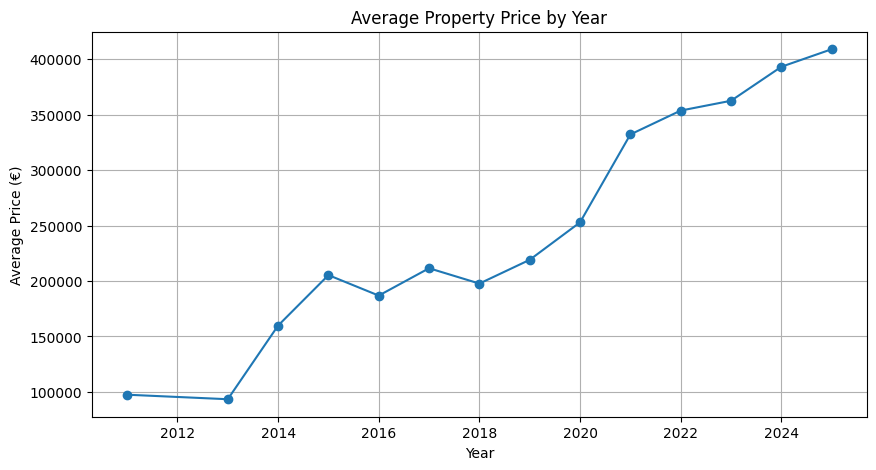

In [23]:
# Aggregate price by year
yearly_avg = eircode_properties.groupby('SaleYear')['Price'].mean()

plt.figure(figsize=(10, 5))
yearly_avg.plot(marker='o')
plt.title('Average Property Price by Year')
plt.ylabel('Average Price (€)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

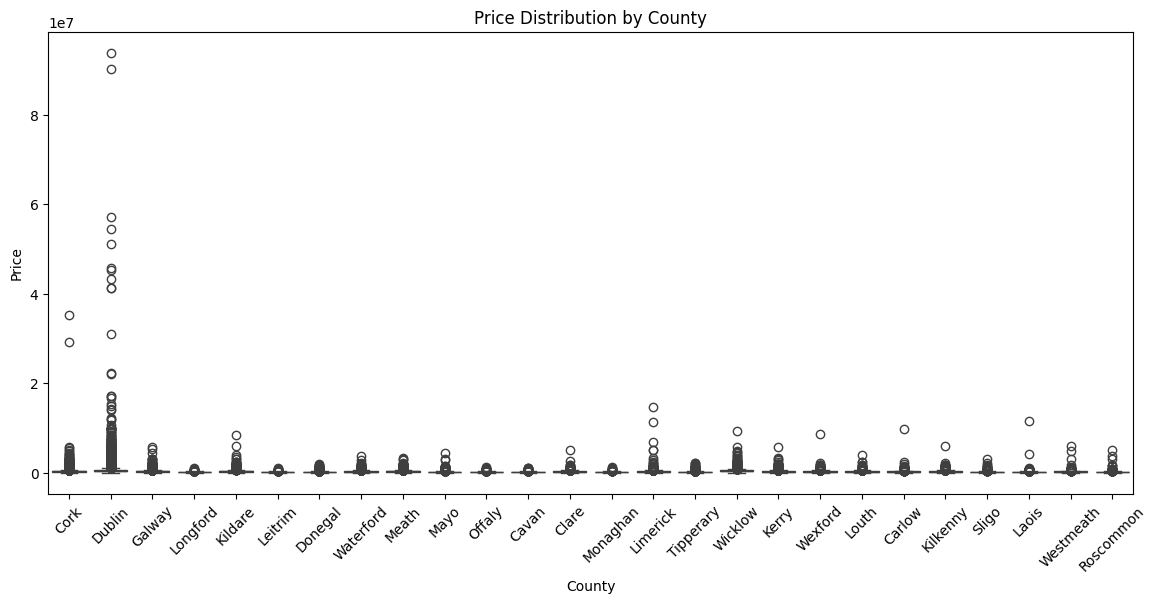

In [25]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='County', y='Price', data=eircode_properties)
plt.xticks(rotation=45)
plt.title('Price Distribution by County')
plt.show()

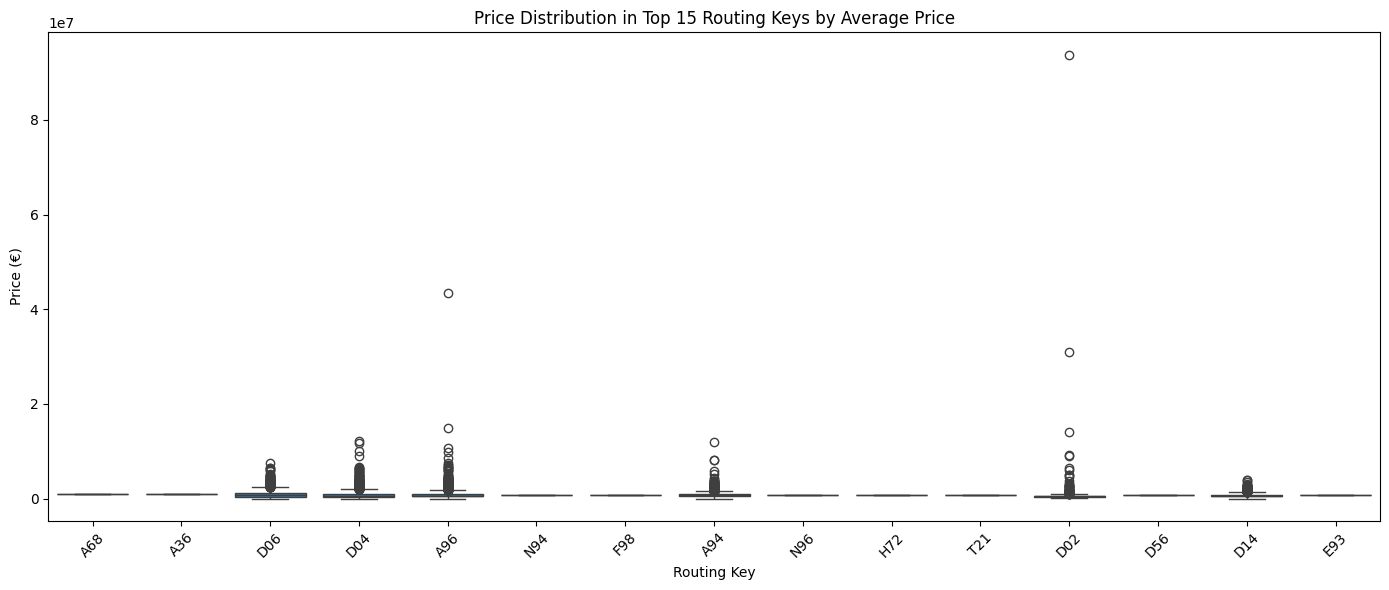

In [29]:
top_15_by_price = (
    eircode_properties.groupby('routing_key')['Price']
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Filter dataframe for those counties only
df_top_15_price = eircode_properties[eircode_properties['routing_key'].isin(top_15_by_price)]

# Plot boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x='routing_key', y='Price', data=df_top_15_price, order=top_15_by_price)
plt.xticks(rotation=45)
plt.title('Price Distribution in Top 15 Routing Keys by Average Price')
plt.ylabel('Price (€)')
plt.xlabel('Routing Key')
plt.tight_layout()
plt.show()

It seems as though 'Date of Sale' and 'Routing Key' are significant indicators of Property Price, so we will use those features to make our predictions.

## Model Training and Predictions

We will use the SaleDate and Routing Key to make predictions of Price by training an XGBoost Regression model.

As we are working with tabular data, it makes more sense to use XGBoost than a deep-learning approach for computational efficiency.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [73]:
# Use only relevant features
df = eircode_properties[['SaleYear', 'SaleMonth', 'routing_key', 'Price']]

In [76]:
df

,SaleYear,SaleMonth,routing_key,Price,routing_key_encoded
24028,2011,3,P43,97500.0,173
70977,2013,4,T23,25000.0,215
73124,2013,5,D11,216000.0,45
73817,2013,6,H91,200000.0,129
74823,2013,6,N39,35000.0,149
...,...,...,...,...,...
726366,2025,6,N39,276000.0,149
726367,2025,6,V35,110000.0,231
726369,2025,6,F26,495000.0,90
726370,2025,6,F12,277000.0,83


In [75]:
'''
Routing Keys are categorical data, we need to encode them as numbers to train our model. We'll use Label Encoding rather than One-Hot
Encoding due to the high cardinality of this feature.
'''
label_encoders = {}
for col in ['routing_key']:
    df[col] = df[col].astype(str).str.strip().str.upper()
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

C:\Users\mcalk\AppData\Local\Temp\ipykernel_10228\3284815130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.strip().str.upper()
C:\Users\mcalk\AppData\Local\Temp\ipykernel_10228\3284815130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_encoded'] = le.fit_transform(df[col])


In [77]:
X = df[['SaleYear', 'SaleMonth', 'routing_key_encoded']]
y = df['Price']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [79]:
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Quick model evaluation using Mean Absolute Error

In [80]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 143206.38


Creating an example to test our model to make a prediction.

In [117]:
sample_data = {
    'SaleYear': [2025],
    'SaleMonth': [6],
    'routing_key': ['R93'],
}

sample_df = pd.DataFrame(sample_data)

In [118]:
for col in ['routing_key']:
    le = label_encoders[col]
    sample_df[f'{col}_encoded'] = le.transform(sample_df[col].astype(str))

In [119]:
sample_df = sample_df.drop('routing_key', axis=1)

In [120]:
predicted_price = model.predict(sample_df)
print(f"Predicted Price: €{predicted_price[0]:,.2f}")

Predicted Price: €302,802.75


Using Pickle to store our model for use later.

In [121]:
import pickle

In [122]:
with open('../web_app/xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the label encoders dictionary
with open('../web_app/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)